In [2]:
%matplotlib widget
from i_o import Paths, RegisteredVolumeReader, VolumeReader
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py, json
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid, get_clipped_array, AVWriter2
from cupyx.scipy.ndimage import maximum_filter, median_filter, convolve1d
from signal_extraction import peristimulus_histogram, stimulus_correlation
from widgets import play_video_widget
from matplotlib.gridspec import GridSpec
from util import plot_traces

from collections import defaultdict
import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import ortho_views_widget

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [7]:
psf_name = "20250904_1834_PSF_LB_10x_noap"
bg_name = "20250815_1938_LBKK_backfill_25x_zf5499i_1_20fps_bg.npy"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"
pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_psfs = r"~/hpc-rw/lfm/psfs"


dataset_names=["20250818_2304_LB_zf552_25x_f5_audiostim_40fps_1",
"20250818_2300_LB_zf552_25x_f5_audiostim_40fps_1",
"20250818_2255_LB_zf552_25x_f5_audiostim_40fps_2",
"20250818_2252_LB_zf552_25x_f5_audiostim_75fps_2",
"20250818_2247_LB_zf552_25x_f5_audiostim_75fps_1",
"20250818_2232_LB_zf552_25x_f4_audiostim_75fps_1",
"20250818_2228_LB_zf552_25x_f4_audiostim_40fps_1",
"20250818_2208_LB_zf552_25x_f3_audiostim_40fps_3",
"20250818_2204_LB_zf552_25x_f3_audiostim_40fps_2",
"20250818_2159_LB_zf552_25x_f3_audiostim_40fps_1",
"20250818_2152_LB_zf552_25x_f3_audiostim_75fps_2",
"20250818_2146_LB_zf552_f25x_f3_audiostim_75fps_1",
"20250818_2117_LB_zf552_f25x_f2_audiostim_40fps_2",
"20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1",
"20250818_2107_LB_zf552_f25x_f2_audiostim_75fps_2",
"20250818_2102_LB_zf552_f25x_f2_audiostim_75fps_1",
"20250818_2035_LB_zf552_f25x_f1_audiostim_75fps_2",
"20250818_2030_LB_zf552_f25x_f1_audiostim_75fps_1",
"20250818_2026_LB_zf552_f25x_f1_audiostim_40fps_4",
"20250818_2021_LB_zf552_f25x_f1_audiostim_40fps_3",
"20250818_2016_LB_zf552_f25x_f1_audiostim_40fps_2",
"20250818_2012_LB_zf552_f25x_f1_audiostim_40fps"
]
means = []
for name in dataset_names:
    paths = Paths(dataset_name=name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )
    reader = VolumeReader(paths.raw, "data", prefetch = 10)
    set_means = []
    for i, vol in tqdm(reader):
        set_means.append(cp.asarray(vol).flatten().mean().get())
    means.append(np.array(set_means))
    print(reader.get_shape("data"))
means = [i[i!=0] for i in means]
for i, arr in enumerate(means):
    if arr.shape[0] >10000 :
        means[i] = np.interp(np.arange(0, len(arr) * 40 / 75), np.arange(len(arr)), arr)
means = np.array([i[:min([i.shape[0] for i in means])] for i in means])
np.save("raw_movement_means.npy", means)

  0%|          | 0/7219 [00:00<?, ?it/s]

(7219, 2048, 2048)


  0%|          | 0/7219 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:

import signal_extraction
import importlib
import numpy as np

importlib.reload(signal_extraction)
from signal_extraction import peristimulus_histogram, stimulus_correlation

pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250814_1646_LB_40fps_bg.npy"
dataset_name = "20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1"

import i_o
importlib.reload(i_o)
from i_o import Paths, get_stimulus, parse_combinations

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,)

traces = np.array(lazyh5(paths.traces)["traces"])
segmentation = np.array(lazyh5(paths.traces)["segmentation"])
timestamps = lazyh5(paths.raw)["tstmp"]
bool_stim, stim_names_og,  final_stimulus_id_fps, final_stimulus, samplerate = get_stimulus(
    "/home/lubo12/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1", timestamps, fps=40)
combinations = parse_combinations(stim_names_og, {
    "Right pulse": ["angle90.0", "gammatone"],
    "Left pulse": ["angle270.0", "gammatone"],
    "Right sine": ["angle90.0", "0.9s"],
    "Left sine": ["angle270.0", "0.9s"],
})
bool_stim, stim_names,  final_stimulus_id_fps, final_stimulus, samplerate = get_stimulus(
    "/home/lubo12/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1", timestamps, fps=40, lag_frames=12, combinations=combinations)

stim_names = {0: 'Right pulse', 1: 'Left pulse', 2: 'Right sine', 3: 'Left sine'}
bool_stim = bool_stim[:, -4:]


# df = np.zeros(shape= psth.shape[:2])
# pad = 30
# # psth = peristimulus_histogram(traces-traces[~np.isnan(traces)].mean(axis=0), bool_stim, pad = pad)
# signal_lag_frames = 3
# for stim in range(psth.shape[0]):
#     stim_length = (np.where(np.diff(bool_stim[:,stim].astype(int))==-1)[0]-np.where(np.diff(bool_stim[:,stim].astype(int))==1)[0]).max() + signal_lag_frames
#     stim_avg_traces = cp.asarray(psth[stim,:,:,0])
#     df[stim,:] = (stim_avg_traces[:,pad:pad+stim_length].mean(axis=1)-stim_avg_traces[:,:pad].mean(axis=1)).get()
    
# sorted_indexes = np.argsort(df, axis = 1)


# n_top_traces = 10000
# percent = 20
# pad = 20
# norm_traces = traces - np.nanmean(traces, axis=0)

# plot_data = []
# for i in range(bool_stim.shape[1]):
#     idx = np.random.choice(sorted_indexes[i, :n_top_traces], int(n_top_traces / percent))
#     psth = peristimulus_histogram(norm_traces[:, idx], bool_stim, pad=pad)[i]
#     pooled_mean = psth[:, :, 0].mean(axis=0)
#     pooled_std = np.sqrt((psth[:, :, 1] ** 2 + psth[:, :, 0] ** 2).mean(axis=0) - pooled_mean ** 2)
#     frames = np.arange(pooled_mean.shape[0])
#     start = pad
#     stim_length = (np.where(np.diff(bool_stim[:, i].astype(int)) == -1)[0] -
#                    np.where(np.diff(bool_stim[:, i].astype(int)) == 1)[0]).max()
#     plot_data.append({
#         "frames": frames,
#         "pooled_mean": pooled_mean,
#         "pooled_std": pooled_std,
#         "start": start,
#         "stim_length": stim_length,
#         "title": stim_names[i]
#     })

# # Save plot_data for later use
# import pickle
# with open("movement_stim_evoked_activity.pkl", "wb") as f:
#     pickle.dump(plot_data, f)
    

In [22]:
bool_stim, stim_names,  final_stimulus_id, final_stimulus, samplerate = get_stimulus(
    "/home/lubo12/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1", timestamps, fps=40)
stim_names_og

{0: 'Silence',
 1: 'gammatone_4e+02Hz_79Pa-1pi_2.7ms2-1pi_angle90.0',
 2: 'gammatone_4e+02Hz_79Pa-1pi_2.7ms2-1pi_angle270.0',
 3: 'gammatone_8e+02Hz_79Pa-1pi_2.7ms2-1pi_angle90.0',
 4: 'gammatone_8e+02Hz_79Pa-1pi_2.7ms2-1pi_angle270.0',
 5: 'gammatone_1.2e+03Hz_79Pa-1pi_2.7ms2-1pi_angle90.0',
 6: 'gammatone_1.2e+03Hz_79Pa-1pi_2.7ms2-1pi_angle270.0',
 7: 'tone_0.9s_400Hz_22PaMonopoleWave2D_distance0.03m_angle90.0',
 8: 'tone_0.9s_400Hz_22PaMonopoleWave2D_distance0.03m_angle270.0',
 9: 'tone_0.9s_800Hz_22PaMonopoleWave2D_distance0.03m_angle90.0',
 10: 'tone_0.9s_800Hz_22PaMonopoleWave2D_distance0.03m_angle270.0',
 11: 'tone_0.9s_1200Hz_22PaMonopoleWave2D_distance0.03m_angle90.0',
 12: 'tone_0.9s_1200Hz_22PaMonopoleWave2D_distance0.03m_angle270.0'}

In [10]:
final_stimulus_id_fps.shape

(7219,)

In [15]:
lazyh5(paths.psf)

<IPython.core.display.JSON object>

In [32]:
import importlib, i_o
importlib.reload(i_o)
from widgets import play_video_widget
from video import AVWriter2, create_projection_image_heatmap
from i_o import VolumeReader, RegisteredVolumeReader
# zpos = lazyh5(paths.deconvolved)["zpos"]
zpos = lazyh5(paths.psf)["z_positions"]
ref_vol = lazyh5(paths.registered)["ref_vol"][10:-5,:,:]
mask = cp.asarray(lazyh5(paths.reg_mask)["mask_3d"][:,:,:])
tau = 50

bool_stim, stim_names,  final_stimulus_id, final_stimulus, samplerate = get_stimulus(
    "/home/lubo12/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1", timestamps, fps=40)

# reader = RegisteredVolumeReader(paths, mask = mask,idx = np.arange(100,300),prefetch=3)
reader = VolumeReader(paths.registered, "data",prefetch=30)
dff_video_fn = paths.pn_outrec + f'/final_vid_df_40fps.mp4'
video_fn = paths.pn_outrec + f'/final_vid_40fps.mp4'

dff_video_writer = AVWriter2(dff_video_fn, fps=40, expected_indeces= reader.i_frames, verbose=False, out_fmt="rgb24",bit_rate=15000000 )
video_writer = AVWriter2(video_fn, fps=40, expected_indeces= reader.i_frames, verbose=False, bit_rate=15000000)

average_vol = None
for frame_n, vol in tqdm(reader, desc="dff_vid"):
    vol = cp.asarray(vol)[10:-5,:,:]
    if average_vol is None:
        average_vol = cp.ones_like(vol, dtype=cp.float32) 
    mip = create_projection_image(vol, vmax=13, vmin=0, absolute_limits=True, text_size = 1,
                                  zpos=zpos, scalebar=200,transpose=True,
                                 
                                  text=f"{stim_names[final_stimulus_id[int(frame_n)]]} f{frame_n}")
    video_writer.write(mip, frame_n)
    average_vol = (1/tau) * vol+ (1-1/tau) * average_vol
    dff_vol = vol - average_vol
    dff_mip = create_projection_image_heatmap(vol, -dff_vol,
                                            vmax=17, vmin=0, absolute_limits=True, text_size = 1,
                                            zpos=zpos, scalebar=200, heatmap_vmin = 0.05, heatmap_vmax=0.3, alpha = 0,transpose=True, pad = 25,
                                            
                                            text=f"{stim_names[final_stimulus_id[int(frame_n)]]} f{frame_n}",)
    dff_video_writer.write(dff_mip, frame_n)
dff_video_writer.close()
video_writer.close()


dff_vid:   0%|          | 0/7219 [00:00<?, ?it/s]

(-0.5, 5.0)

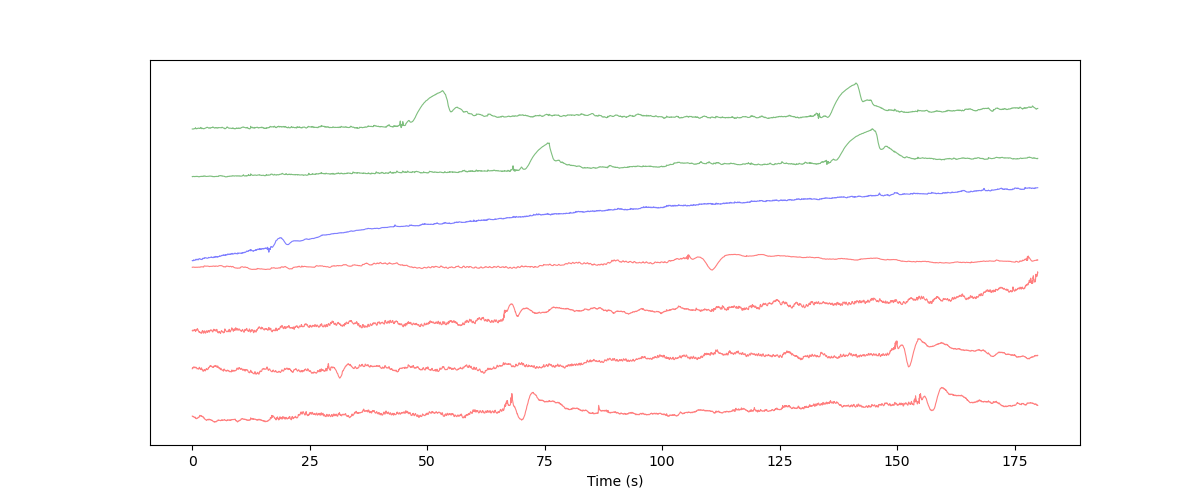

In [11]:

means = np.load("raw_movement_means.npy")
means -= means.mean(axis=1, keepdims=True)
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_traces(-means.T[:,(0,1,2,3,6,12,13)],n=7, ax = ax, mask = np.ones_like(means[:,0]),fps = 40, scale_factor = 0.7, y_add=1, colors = ["red"]*4+["blue"]+["green"]*2)
ax.set_yticks([])
ax.set_ylim(-0.5,5)

In [9]:
traces_data = lazyh5(paths.traces)
traces = traces_data["traces"]
segmentation = traces_data["segmentation"]
trace_mask = np.ones(shape=(7219,))
trace_mask[1764:1796]=0
trace_mask[5322:5342]=0
trace_mask[7198:]=0
trace_mask = trace_mask.astype(bool)
print(np.unique(segmentation).shape)
traces_data

(211580,)


<IPython.core.display.JSON object>

In [10]:
lazyh5(paths.psf)["z_positions"]

array([9.35466766, 9.35281277, 9.35078144, 9.34876919, 9.34693336,
       9.34501934, 9.34285164, 9.34076214, 9.33876991, 9.33685589,
       9.33486366, 9.33273411, 9.33111286, 9.32906246, 9.32683563,
       9.32482433, 9.32281208, 9.32083988, 9.31876945, 9.31695271,
       9.31494141, 9.31289101, 9.31089878, 9.30894566, 9.30724621,
       9.30486298, 9.30289078, 9.30082035, 9.2990427 , 9.2968359 ,
       9.29498005, 9.29296875, 9.29101562, 9.28888702, 9.28714848,
       9.28509808, 9.28304672, 9.2810545 , 9.2790432 , 9.27697277,
       9.2754879 , 9.27298832, 9.27095699, 9.26894569, 9.26712894,
       9.26511765, 9.26296902, 9.26126957, 9.25914097, 9.25699234,
       9.25511742, 9.25322247, 9.25126934, 9.24927711, 9.24710941,
       9.24533176, 9.24316406, 9.24138641, 9.23908234, 9.23734379,
       9.23509789, 9.23316383, 9.23128891, 9.22919941, 9.22720718,
       9.22515583, 9.22326183, 9.22134781, 9.21919918, 9.21712875,
       9.21529293, 9.21320343, 9.21123028, 9.20923805, 9.20740

In [12]:
data = traces[trace_mask]
data -= data.mean(axis=0)
from sklearn.utils.extmath import randomized_svd
n_components = 150
u, s, v = randomized_svd(data, n_components=n_components, random_state=42)


/tmp/ipykernel_3181948/2240167476.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(- 0.5,data["stim_length"] - 0.5,
/tmp/ipykernel_3181948/2240167476.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


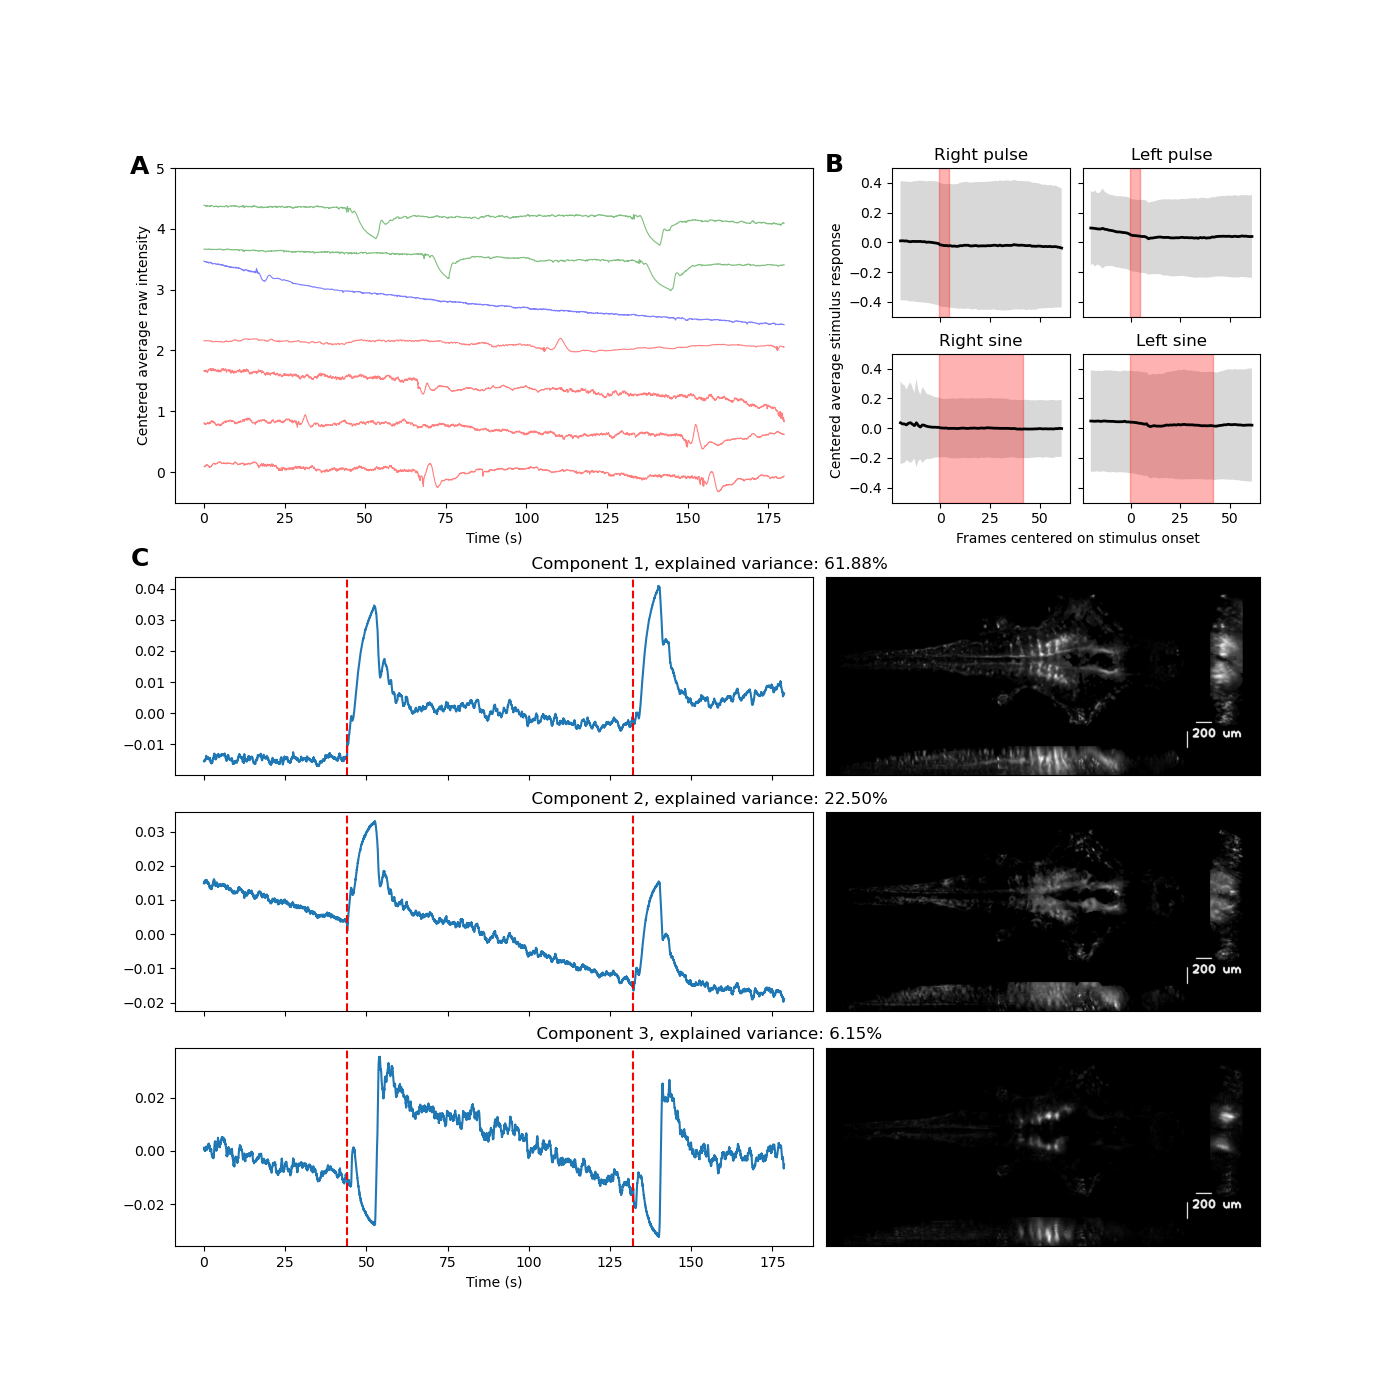

In [18]:
fig = plt.figure(figsize=(14, 14))
movement_points = [1764, 5322-(1796-1764)]  

gs = GridSpec(6, 4, figure=fig, height_ratios=[0.75,0.75,0.0,1,1,1], width_ratios=[1.8,0.15,0.5,0.5], 
              hspace=0.25, wspace=0.05)
ax = fig.add_subplot(gs[:2,0])
means = np.load("raw_movement_means.npy")
means -= means.mean(axis=1, keepdims=True)
plot_traces(means.T[:,(0,1,2,3,6,12,13)],n=7, ax = ax, mask = np.ones_like(means[:,0]),fps = 40, scale_factor = 0.7, y_add=1, colors = ["red"]*4+["blue"]+["green"]*2)
# ax.set_yticks([])

ax.set_ylim(-0.5,5)
ax.set_ylabel("Centered average raw intensity")
# ax.set_xlabel("")
ax.text(-0.07, 1.04, "A", transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')



stim_axes = [fig.add_subplot(gs[0, 2]),fig.add_subplot(gs[0, 3]),fig.add_subplot(gs[1, 2]),fig.add_subplot(gs[1, 3])]



with open("movement_stim_evoked_activity.pkl", "rb") as f:
    plot_data = pickle.load(f)

for i, data in enumerate(plot_data):
    ax = stim_axes[i]
    ax.fill_between(data["frames"]-data["start"], data["pooled_mean"] - data["pooled_std"],
                    data["pooled_mean"] + data["pooled_std"], color='gray', alpha=0.3, edgecolor='none')
    ax.plot(data["frames"]-data["start"], data["pooled_mean"], color='black', lw=2)
    ax.axvspan(- 0.5,data["stim_length"] - 0.5,
               color="red", alpha=0.3, edgecolor='none')
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(data["title"])

stim_axes[0].set_xticklabels([])
stim_axes[1].set_xticklabels([])
stim_axes[1].set_yticklabels([])
stim_axes[3].set_yticklabels([])
# For shared y-label (left side of both top and bottom stimulus axes)
fig.text(0.598, 0.75, "Centered average stimulus response", va='center', ha='center', rotation='vertical', fontsize=10,)

# For shared x-label (bottom of both bottom stimulus axes)
fig.text(0.77, 0.615, "Frames centered on stimulus onset", va='center', ha='center', fontsize=10,)
stim_axes[0].text(-0.38, 1.1, "B", transform=stim_axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')



axes = [fig.add_subplot(gs[i+3, 0]) for i in range(3)]
spatial_axes = [fig.add_subplot(gs[i+3, 1:]) for i in range(3)]
axes[0].text(-0.07, 1.15, "C", transform=axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')


fps = 40
for i, ax in enumerate(axes):
    temporal_trace = u[:, i]
    time_axis = np.arange(u.shape[0]) / fps
    ax.plot(time_axis, temporal_trace)
    # ax.set_ylabel("Amplitude")
    if i == 2:
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xticklabels([])
    # ax.set_yticks([])
    var = s[i]**2 /(s**2).sum()
    ax.set_title(f"                                                                                  Component {i+1}, explained variance: {var*100:.2f}%")
    for mp in movement_points:
        ax.axvline(mp/fps, color='r', linestyle='--')
for i, ax in enumerate(spatial_axes):
    spatial_trace = np.zeros(v.shape[1]+1, dtype = v.dtype)
    spatial_trace[1:]=-(v[i,:])
    volume = spatial_trace[segmentation]
    ax.imshow(create_projection_image(volume, scalebar=200,zpos=lazyh5(paths.psf)["z_positions"], text_size = 2, transpose =True), cmap="gray",  aspect='auto')
    ax.set_yticks([])
    ax.set_xticks([])
    # ax.set_ylabel(f"Component {i+1}")
fig.tight_layout()

In [77]:
fig.tight_layout()

    

/tmp/ipykernel_2003217/2671018249.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
